## This notebook shows how to use Orchestrator APIs for user experiments

In [4]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [5]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [6]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [7]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: UKY: { cpu: 6/6 , core: 188/192 , ram: 1,524/1,536 G, disk: 9,580/9,600 G, unit: 3/3 }
	Components:
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 9,000/10,000 G, unit: 9/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 379/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
		UKY_LBNL: TrunkPort { bw: 100/100 Gbps}
RENC
	Components:
	Site Interfaces:
STAR
	Components:
	Site Interfaces:
LBNL: { cpu: 6/6 , core: 190/192 , ram: 1,530/1,536 G, disk: 9,590/9,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-

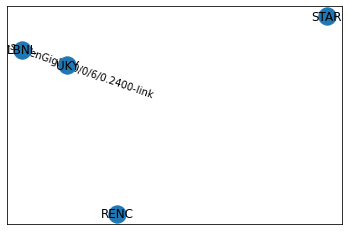

In [8]:
if status == Status.OK:
    advertised_topology.draw()
else:
    print(f"Error: {advertised_topology}")

## Create Slice

We are going to request the setup below:

<img src="./l2bridge-dedicated-untagged.png">

In [10]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='LBNL')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='c1')

# Add node
n2 = t.add_node(name='n2', site='LBNL')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Dedicated Cards
n1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name='n2-nic1')

# L2Bridge Service
t.add_network_service(name='bridge1', nstype=ServiceType.L2Bridge, interfaces=t.interface_list)

# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-l2bridge-ded-untag', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "80767034-0da6-4d0d-bbf7-2b827712553e",
    "lease_end": "2021-08-09 18:03:13",
    "pending_state": "None_",
    "reservation_id": "1242d3a2-d113-437b-80cc-0728b3b5836f",
    "reservation_state": "Unknown",
    "slice_id": "2320c8fc-c4e5-4a90-aea1-e2c5bc42f691"
}, {
    "graph_node_id": "37182100-d0d8-47cf-999d-9ec558492f20",
    "lease_end": "2021-08-09 18:03:13",
    "pending_state": "None_",
    "reservation_id": "81eb07b6-4e79-4de1-9e4f-f8b41f06c2ea",
    "reservation_state": "Unknown",
    "slice_id": "2320c8fc-c4e5-4a90-aea1-e2c5bc42f691"
}, {
    "graph_node_id": "ce64dc0d-f8f1-489a-99ea-145408356bef",
    "lease_end": "2021-08-09 18:03:13",
    "pending_state": "None_",
    "reservation_id": "a3a44787-b320-45de-bf5f-43c6ad13a4af",
    "reservation_state": "Unknown",
    "slice_id": "2320c8fc-c4e5-4a90-aea1-e2c5bc42f691"
}]


In [11]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [21]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "74692b50-c32f-4976-aa8c-5c2d63ea5e54",
    "lease_end": "2021-08-09 18:03:13",
    "slice_id": "2320c8fc-c4e5-4a90-aea1-e2c5bc42f691",
    "slice_name": "Slice-l2bridge-ded-untag",
    "slice_state": "StableOK"
}]


## Query Slivers

In [20]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000000e7\", \"instance_parent\": \"lbnl-w3.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "37182100-d0d8-47cf-999d-9ec558492f20",
    "join_state": "NoJoin",
    "lease_end": "2021-08-09 18:03:13",
    "management_ip": "198.129.61.62",
    "name": "n2",
    "pending_state": "None_",
    "reservation_id": "81eb07b6-4e79-4de1-9e4f-f8b41f06c2ea",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "LBNL",
    "slice_id": "2320c8fc-c4e5-4a90-aea1-e2c5bc42f691"
}, {
    "graph_node_id": "ce64dc0d-f8f1-489a-99ea-145408356bef",
    "join_state": "NoJoin",
    "lease_end": "2021-08-09 18:03:13",
    "name": "bridge1",
    "pending_state": "None_",
    "reservation_id": "a3a44787-b320-45de-bf5

In [22]:
import paramiko

In [23]:
slivers[0].management_ip

'198.129.61.62'

In [24]:
slivers[2].management_ip

'198.129.61.53'

In [25]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client1 = paramiko.SSHClient()
client1.load_system_host_keys()
client1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client1.connect(slivers[0].management_ip,username='ubuntu',pkey = key)

client1

In [26]:
stdin, stdout, stderr = client1.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.2 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [27]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client2 = paramiko.SSHClient()
client2.load_system_host_keys()
client2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client2.connect(slivers[2].management_ip,username='ubuntu',pkey = key)

client2

In [28]:
stdin, stdout, stderr = client2.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.2 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



### We will need to use the `route` command. So we need to install `net-tools`.

In [31]:
stdin, stdout, stderr = client1.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [792 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [156 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8408 B]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [330 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [47.6 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [460 B]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [635 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [98.5 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/univer

In [32]:
stdin, stdout, stderr = client2.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [792 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [156 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8408 B]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [330 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [47.6 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [460 B]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [635 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [98.5 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/univer

In [34]:
stdin, stdout, stderr = client1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:47:68:67 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.194/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86213sec preferred_lft 86213sec
    inet6 fe80::f816:3eff:fe47:6867/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:91:75:12 brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:91:75:13 brd ff:ff:ff:ff:ff:ff




In [33]:
stdin, stdout, stderr = client2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:f7:5a:14 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.150/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86238sec preferred_lft 86238sec
    inet6 fe80::f816:3eff:fef7:5a14/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:18:ac brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:18:ad brd ff:ff:ff:ff:ff:ff




## We can see above that each of the nodes has the network interfaces `ens7` and `ens8`.

## Below, we are going to do the following to each of the interfaces:

- Assign an IP address to it (example: `sudo ip addr add 192.168.10.51/24 dev ens7`)
- Activate it (example: `sudo ip link set dev ens7 up`)
- Make a route connecting the interface to the other corresponding interface. _We will connect `eth7` to `eth7`, and `eth8` to `eth8`._ (example: `route add -net 192.168.10.0/24 dev ens7`)

In [35]:
stdin, stdout, stderr = client1.exec_command('sudo ip addr add 192.168.10.51/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [36]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [37]:
stdin, stdout, stderr = client1.exec_command('sudo route add -net 192.168.12.0/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [38]:
stdin, stdout, stderr = client1.exec_command('sudo ip addr add 192.168.11.51/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [39]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [40]:
stdin, stdout, stderr = client1.exec_command('sudo route add -net 192.168.13.0/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [41]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.12.51/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [42]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [43]:
stdin, stdout, stderr = client2.exec_command('sudo route add -net 192.168.10.0/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [44]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.13.51/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [45]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [46]:
stdin, stdout, stderr = client2.exec_command('sudo route add -net 192.168.11.0/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

## Now let's ping

<!-- _We are going to monitor the ping packets received on client1 through terminals. It might be a hassle to get around the blocking._ -->

In [47]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=0.323 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=0.073 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=0.138 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=0.071 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=0.064 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4091ms
rtt min/avg/max/mdev = 0.064/0.133/0.323/0.098 ms




In [48]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.11.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.11.51 (192.168.11.51) 56(84) bytes of data.
64 bytes from 192.168.11.51: icmp_seq=1 ttl=64 time=0.173 ms
64 bytes from 192.168.11.51: icmp_seq=2 ttl=64 time=0.080 ms
64 bytes from 192.168.11.51: icmp_seq=3 ttl=64 time=0.067 ms
64 bytes from 192.168.11.51: icmp_seq=4 ttl=64 time=0.068 ms
64 bytes from 192.168.11.51: icmp_seq=5 ttl=64 time=0.070 ms

--- 192.168.11.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4099ms
rtt min/avg/max/mdev = 0.067/0.091/0.173/0.040 ms




### `n2` is able to reach `n1` at the IPs that we've assigned.

In [49]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.12.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.12.51 (192.168.12.51) 56(84) bytes of data.
64 bytes from 192.168.12.51: icmp_seq=1 ttl=64 time=0.113 ms
64 bytes from 192.168.12.51: icmp_seq=2 ttl=64 time=0.050 ms
64 bytes from 192.168.12.51: icmp_seq=3 ttl=64 time=0.054 ms
64 bytes from 192.168.12.51: icmp_seq=4 ttl=64 time=0.066 ms
64 bytes from 192.168.12.51: icmp_seq=5 ttl=64 time=0.090 ms

--- 192.168.12.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4078ms
rtt min/avg/max/mdev = 0.050/0.074/0.113/0.023 ms




In [50]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.13.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.13.51 (192.168.13.51) 56(84) bytes of data.
64 bytes from 192.168.13.51: icmp_seq=1 ttl=64 time=0.125 ms
64 bytes from 192.168.13.51: icmp_seq=2 ttl=64 time=0.051 ms
64 bytes from 192.168.13.51: icmp_seq=3 ttl=64 time=0.049 ms
64 bytes from 192.168.13.51: icmp_seq=4 ttl=64 time=0.078 ms
64 bytes from 192.168.13.51: icmp_seq=5 ttl=64 time=0.068 ms

--- 192.168.13.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4089ms
rtt min/avg/max/mdev = 0.049/0.074/0.125/0.027 ms




### `n1` is able to reach `n2` at the IPs that we've assigned.